In [211]:
using Plots
using NBInclude
using FFTW
@userplot CirclePlot
@nbinclude("Eulergrid.ipynb")
@nbinclude("Operators.ipynb")
@nbinclude("ImmersedBnd.ipynb")

BndIntegral (generic function with 1 method)

In [212]:
N=100    ####Size of boundary
Nx=200     ####Size of grid
Ny=400
mygrid=PeriodicEulergrid(Nx,Ny); ###defining the grid

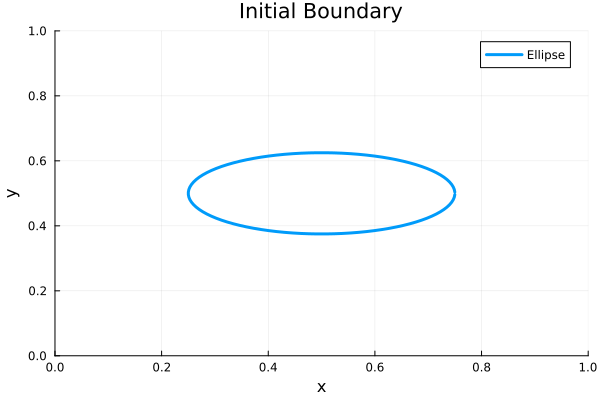

In [213]:
theta=collect(2pi/2N:2pi/N:2pi-2pi/2N) ####Parameter for boundary
x=0.25 .*cos.(theta) .+0.5; #Boundary coordinates 
y=0.125 .*sin.(theta) .+0.5;
mybnd=PeriodicLagrangianBoundary(x,y); ###Defining the boundary 
plot(mybnd.bnd_loc[:,1],mybnd.bnd_loc[:,2],ylimits=(0,1),xlimits=(0,1),title="Initial Boundary", label="Ellipse", linewidth=3)
xlabel!("x")
ylabel!("y")

In [214]:
force=Vectordata(mygrid) ##Initializing force as vector defined on Euler grid
f_x=Vectordata(mygrid).U; ##x-component of force
f_y=Vectordata(mygrid).V; ##y-component of force
pressurevalues=coordinatedata(mygrid); ##Initializing the pressure
fluid_velocity=Vectordata(mygrid); ###Initializing the velocity on Euler grid

[ Info: Saved animation to /Users/umairaliwani/IBM/Bnd.gif


Plots.AnimatedGif("/Users/umairaliwani/IBM/Bnd.gif")
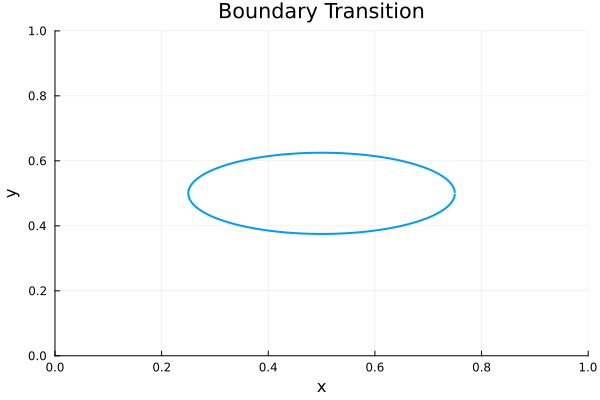

In [215]:
dt=0.01
mu=1.0
n_iter=1000
width=zeros(n_iter)
anim=Animation()
for i in 1:n_iter
    u_bnd=ScalarBndInterp(fluid_velocity.U,mybnd,mygrid) ###Getting the velocity of boundary, the first component
    v_bnd=ScalarBndInterp(fluid_velocity.V,mybnd,mygrid) ###Getting the velocity of boundary, the second component
    mybnd.bnd_loc[:,1]=mybnd.bnd_loc[:,1]+dt*u_bnd; ##modifying the location of boundary points using velocity of boundary
    mybnd.bnd_loc[:,2]=mybnd.bnd_loc[:,2]+dt*v_bnd;
    mybnd=PeriodicLagrangianBoundary(mybnd.bnd_loc[:,1],mybnd.bnd_loc[:,2]); #New location of boundary
    (f_x,f_y)=VectorBndSpread(mybnd.stretch_force,mybnd,mygrid);   ####force on fluid applied by immersed boundary
    divergencedata=Divergenceoperator(mygrid) #Getting the FFT frequencies
    gradientdata=Gradientoperator(mygrid)
    f_xfft=FFTW.fft(f_x).*Divergenceoperator(mygrid).UxFrequencymultiples #To find the divergence in Fourier space use this formula for Ist-comp 
    f_yfft=FFTW.fft(f_y).*Divergenceoperator(mygrid).VyFrequencymultiples #Similar to above
    force_transformed= f_xfft + f_yfft
    pressurevalues.U=Invertlaplacianoperator(force_transformed,mygrid) #Pressure data
    phat = FFTW.fft(pressurevalues.U); 
    p_xhat = phat.*gradientdata.UxFrequencymultiples; #Gradient in Fourier space, w.r.t ist-component.
    p_yhat = phat.*gradientdata.VyFrequencymultiples;
    horizRHS = p_xhat-FFTW.fft(f_x);
    horizRHS = horizRHS/mu;
    vertRHS = p_yhat-FFTW.fft(f_y);
    vertRHS = vertRHS/mu;
    fluid_velocity.U=Invertlaplacianoperator(horizRHS,mygrid) #first component of velocity
    fluid_velocity.V=Invertlaplacianoperator(vertRHS,mygrid) #Second component of velocity
    width[i]=maximum(mybnd.bnd_loc[:,1])-minimum(mybnd.bnd_loc[:,1]) #Width of Immersed boundary
   plot(mybnd.bnd_loc[:,1],mybnd.bnd_loc[:,2], ylimits=(0,1),xlimits=(0,1),legend=false,title="Boundary Transition",linewidth=2)
    xlabel!("x")
    ylabel!("y")
        frame(anim)
    end
gif(anim, "Bnd.gif", fps=10)


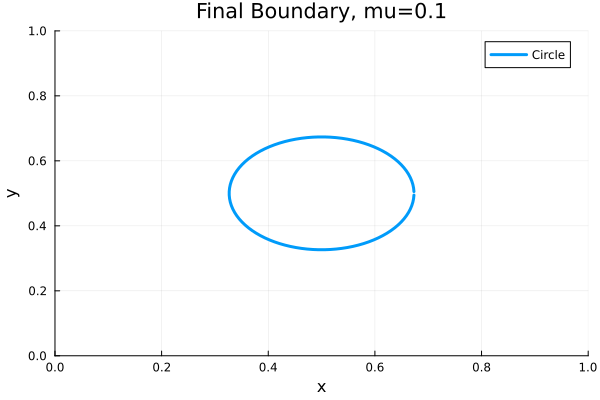

In [216]:
plot(mybnd.bnd_loc[:,1],mybnd.bnd_loc[:,2],ylimits=(0,1),xlimits=(0,1),title="Final Boundary, mu=0.1", label="Circle", linewidth=3)
xlabel!("x")
ylabel!("y")

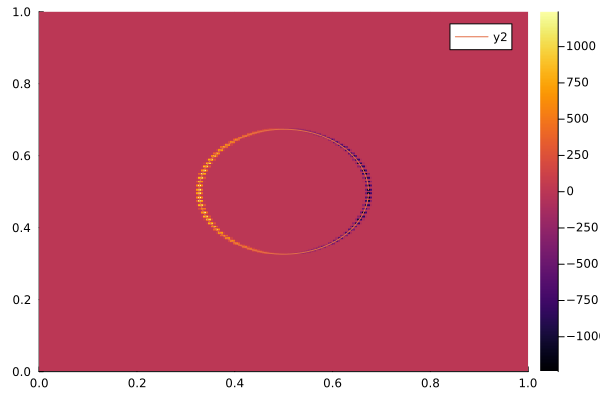

In [217]:
heatmap(mygrid.X[:,1],mygrid.Y[1,:],f_x')
plot!(mybnd.bnd_loc[:,1],mybnd.bnd_loc[:,2],ylimits=(0,1),xlimits=(0,1))